In [1]:
import ROOT as rt

Welcome to JupyROOT 6.30/04


In [2]:
# rt.RooFit.BatchMode
rt.RooFit.EvalBackend

<class cppyy.gbl.RooFit.EvalBackend at 0x556ffe2cd5c0>

In [3]:
# load_path = "workspace/workspace_ggh_All_Zfit_no_e_cut_UL_calib_cat5.root"
load_path = "workspace/workspace_ggh_All_Zfit_no_e_cut_UL_calib_cat5_data_x.root"

In [4]:
file = rt.TFile.Open(load_path)

In [5]:
canvas = rt.TCanvas()
canvas.cd()
mass =  rt.RooRealVar("mh_ggh","mass (GeV)",100,85,99)
mass.setBins(200) # bin to 100 bins otherwise, fitting with FFT conv is gonna take forever
# mass.setBins(10000) # stress test
frame = mass.frame()

In [6]:
bwWidth = rt.RooRealVar("bwz_Width" , "widthZ", 2.5, 0, 30)
bwmZ = rt.RooRealVar("bwz_mZ" , "mZ", 91.2, 90, 92)
sigma = rt.RooRealVar("sigma" , "sigma", 2, 0.0, 5.0)

bwWidth.setConstant(True)
bwmZ.setConstant(True) # set bwmZ 

model1_1 = rt.RooBreitWigner("bwz", "BWZ",mass, bwmZ, bwWidth)

"""
Note from Jan: sometimes freeze n values in DCB to be frozen (ie 1, but could be other values)
This is because alpha and n are highly correlated, so roofit can be really confused.
Also, given that we care about the resolution, not the actual parameter values alpha and n, we can 
put whatevere restrictions we want.
"""
mean = rt.RooRealVar("mean" , "mean", 0, -10,10) # mean is mean relative to BW
sigma = rt.RooRealVar("sigma" , "sigma", 2, .1, 4.0)
alpha1 = rt.RooRealVar("alpha1" , "alpha1", 2, 0.01, 65)
n1 = rt.RooRealVar("n1" , "n1", 10, 0.01, 185)
alpha2 = rt.RooRealVar("alpha2" , "alpha2", 2.0, 0.01, 65)
n2 = rt.RooRealVar("n2" , "n2", 25, 0.01, 385)
n1.setConstant(True)
n2.setConstant(True)
model1_2 = rt.RooCrystalBall("dcb","dcb",mass, mean, sigma, alpha1, n1, alpha2, n2)

# merge BW with DCB
model1 = rt.RooFFTConvPdf("BWxDCB", "BWxDCB", mass, model1_1, model1_2)


mass.setBins(10000,"cache") # This nbins has nothing to do with actual nbins of mass. cache bins is representation of the variable only used in FFT
mass.setMin("cache",50.5) 
mass.setMax("cache",130.5)

coeff = rt.RooRealVar("coeff", "coeff", 0.01, 0.00000001, 1)
# shift = rt.RooRealVar("shift" , "shift", 92, -10, 1000)
# coeff = rt.RooRealVar("coeff", "Slope", 0.0001, -1.5, 0)
shift = rt.RooRealVar("shift", "Offset", 85, 75, 105)
shifted_mass = rt.RooFormulaVar("shifted_mass", "@0-@1", rt.RooArgList(mass, shift))
model2 = rt.RooExponential("Exponential", "Exponential", shifted_mass, coeff)

sigfrac = rt.RooRealVar("sigfrac", "sigfrac", 0.98, 0, 1.0)
model3 = rt.RooAddPdf("model3", "model3", rt.RooArgList(model1, model2),sigfrac)

[#1] INFO:Caching -- Changing internal binning of variable 'mh_ggh' in FFT 'BWxDCB' from 200 to 930 to improve the precision of the numerical FFT. This can be done manually by setting an additional binning named 'cache'.


In [8]:
import time

start = time.time()

#fitting directly to unbinned dataset is slow, so first make a histogram
roo_dataset = file.w.data("data_Zfit_no_e_cut_UL_calib_cat5")
roo_hist = rt.RooDataHist("data_hist","binned version of roo_dataset", rt.RooArgSet(mass), roo_dataset)  # copies binning from mass variable

rt.EnableImplicitMT()
# model3.fitTo(roo_hist, rt.RooFit.BatchMode("cpu"))
model3.fitTo(roo_hist, EvalBackend="cpu")


end = time.time()
print(f"fitting elapsed time: {end - start}")

fitting elapsed time: 1.666719913482666
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(BWxDCB) creating new cache 0x556fff9f7ff0 with pdf bwz_CONV_dcb_CACHE_Obs[mh_ggh]_NORM_mh_ggh for nset (mh_ggh) with code 0
[#1] INFO:Fitting -- RooAbsPdf::fitTo(model3) fixing normalization set for coefficient determination to observables in data
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_model3_data_hist) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
Minuit2Minimizer: Minimize with max-calls 3500 convergence for edm < 1 strategy 1
[#1] INFO:NumericIntegration -- RooRealIntegral::init(Exponential_Int[mh_ggh]) using numeric integrator RooRombergIntegrator to calculate Int(mh_ggh)
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(BWxDCB) creating new cache 0x557000cbe350 with pdf bwz_CONV_dcb_CACHE_Obs[mh_ggh] for nset () with code 1 from preexisting content.
[#1] INFO:NumericIntegration -- 

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =       538554.6444 Edm =       258.1573923 NCalls =     35
Info in <Minuit2>: NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : 538554.6444
  Edm           : 237.2812856
  Internal parameters:	[     -1.346101594     -1.243590154      1.507045511    -0.2691413307    -0.8398369095      1.217157325    -0.4254211392]	
  Internal gradient  :	[      22012.14275     -204.3049487      -19.7121042      15455.84518                0      -703.159958      20661.83176]	
  Internal covariance matrix:
[[  1.4244354e-06              0              0              0              0              0              0]
 [              0  3.0341857e-05              0              0              0              0              0]
 [              0      

[#1] INFO:Caching -- RooAbsCachedPdf::getCache(BWxDCB) creating new cache 0x557000fe01b0 with pdf bwz_CONV_dcb_CACHE_Obs[mh_ggh]_NORM_mh_ggh for nset (mh_ggh) with code 0
[#1] INFO:NumericIntegration -- RooRealIntegral::init(bwz_CONV_dcb_CACHE_Obs[mh_ggh]_NORM_mh_ggh_Int[mh_ggh]) using numeric integrator RooRombergIntegrator to calculate Int(mh_ggh)
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(BWxDCB) creating new cache 0x557000fe01b0 with pdf bwz_CONV_dcb_CACHE_Obs[mh_ggh]_NORM_mh_ggh for nset (mh_ggh) with code 0 from preexisting content.
[#1] INFO:NumericIntegration -- RooRealIntegral::init(bwz_CONV_dcb_CACHE_Obs[mh_ggh]_NORM_mh_ggh_Int[mh_ggh]) using numeric integrator RooRombergIntegrator to calculate Int(mh_ggh)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(Exponential_Int[mh_ggh]) using numeric integrator RooRombergIntegrator to calculate Int(mh_ggh)


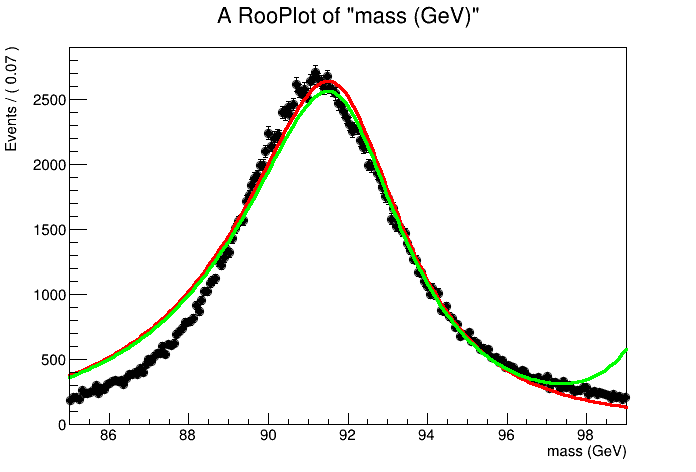

In [9]:
file.w.data("data_Zfit_no_e_cut_UL_calib_cat5").plotOn(frame)

model1.plotOn(frame, rt.RooFit.LineColor(rt.kRed))
# model2.plotOn(frame, rt.RooFit.LineColor(rt.kBlue))
model3.plotOn(frame, rt.RooFit.LineColor(rt.kGreen))


frame.Draw()
canvas.Update()
canvas.Draw()
